In [1]:
import os
import re
import json
import requests
import pandas as pd
import urllib.request
from operator import itemgetter
import pyreadr
import numpy as np
from IPython.display import Image
from sentence_transformers import SentenceTransformer
import graph_utils
from fact_checking import fact_check_and_add, extract_all_patterns, visualize_rules

/Users/wy/Documents/WW-AI-GK/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Connection to graph database established.


## Neo4J AuraDB Setup

### Resetting database

We reset the database to start with a blank slate.

In [2]:
# Removes all nodes and relationships
graph_utils.reset_graph()

In [3]:
# Removes all indexes and constraints
graph_utils.reset_constraints()

## Schema Constraints

In this section, we define constraints and indexes for the various nodes in our graph.

Key constraints and uniqueness constraints will ensure that nodes can be matched unambiguously.
We also employ semantic indexes for the purposes of node disambiguiation:
1. Full-text indexes allow keywords to be matched (e.g. country name aliases can be used to match to different aliases of a particular country)
2. Vector indexes allow similarity based search (e.g. industry description can be used to match to specific industry nodes)

### Region Node

In [4]:
# m49 is key
graph_utils.execute_query('''
CREATE CONSTRAINT region_m49_key IF NOT EXISTS
FOR (r:Region) REQUIRE r.m49 IS NODE KEY''')

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x13354f490>, keys=[])

In [5]:
# name is unique
graph_utils.execute_query('''
CREATE CONSTRAINT region_name_unique IF NOT EXISTS
FOR (r:Region) REQUIRE r.name IS UNIQUE''')

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x12db47b10>, keys=[])

In [6]:
# name fulltext index
graph_utils.execute_query('''
CREATE FULLTEXT INDEX region_name_index IF NOT EXISTS
FOR (r:Region) ON EACH [r.name]''')

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x132d0a0d0>, keys=[])

### Country Node

In [7]:
# iso3 is key
graph_utils.execute_query('''
CREATE CONSTRAINT country_iso3_key IF NOT EXISTS
FOR (c:Country) REQUIRE c.iso3 IS NODE KEY''')

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x133571190>, keys=[])

In [8]:
# iso2 is unique
graph_utils.execute_query('''
CREATE CONSTRAINT country_iso2_unique IF NOT EXISTS
FOR (c:Country) REQUIRE c.iso2 IS UNIQUE''')

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x13356bd50>, keys=[])

In [9]:
# name is unique
graph_utils.execute_query('''
CREATE CONSTRAINT country_name_unique IF NOT EXISTS
FOR (c:Country) REQUIRE c.name IS UNIQUE''')

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x1335717d0>, keys=[])

In [10]:
# aliases fulltext index
graph_utils.execute_query('''
CREATE FULLTEXT INDEX country_aliases_index IF NOT EXISTS
FOR (c:Country) ON EACH [c.aliases]''')

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x133579790>, keys=[])

### Sector Node

In [11]:
# gics is key
graph_utils.execute_query('''
CREATE CONSTRAINT sector_gics_key IF NOT EXISTS
FOR (s:Sector) REQUIRE s.gics IS NODE KEY''')

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x13357a5d0>, keys=[])

In [12]:
# name is unique
graph_utils.execute_query('''
CREATE CONSTRAINT country_name_unique IF NOT EXISTS
FOR (c:Country) REQUIRE c.name IS UNIQUE''')

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x13354de10>, keys=[])

### Industry Node

In [13]:
# gics is key
graph_utils.execute_query('''
CREATE CONSTRAINT industry_gics_key IF NOT EXISTS
FOR (i:Industry) REQUIRE i.gics IS NODE KEY''')

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x133582110>, keys=[])

In [14]:
# name is unique
graph_utils.execute_query('''
CREATE CONSTRAINT industry_name_unique IF NOT EXISTS
FOR (i:Industry) REQUIRE i.name IS UNIQUE''')

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x1053ffb10>, keys=[])

In [15]:
# description vector index
graph_utils.execute_query('''
CREATE VECTOR INDEX industry_description_index IF NOT EXISTS
FOR (i:Industry)
ON i.embedding
OPTIONS { indexConfig: {
 `vector.quantization.enabled`: false
}}''')

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x13357b450>, keys=[])

### Company Node

In [16]:
# ticker is key
graph_utils.execute_query('''CREATE CONSTRAINT company_ticker_key IF NOT EXISTS
FOR (c:Company) REQUIRE c.ticker IS NODE KEY''')

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x133572cd0>, keys=[])

In [17]:
# names fulltext index
graph_utils.execute_query('''CREATE FULLTEXT INDEX company_names_index IF NOT EXISTS
FOR (c:Company) ON EACH [c.names]''')

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x12e321d50>, keys=[])

## Adding Initial Data

### Region Nodes

Our country and region nodes, as well as the IS_IN relationships from countries to regions, are sourced from [UNSD](https://unstats.un.org/unsd/methodology/m49/overview/).

In [18]:
df_m49 = pd.read_csv('../data/UNSD_m49.csv', sep=';')

In [19]:
continents = df_m49[['Region Code', 'Region Name']]\
                    .dropna()\
                    .drop_duplicates()\
                    .rename(columns={
                        'Region Code': 'm49',
                        'Region Name': 'name'
                    })

In [20]:
subregions = df_m49[['Sub-region Code', 'Sub-region Name']]\
                    .dropna()\
                    .drop_duplicates()\
                    .rename(columns={
                        'Sub-region Code': 'm49',
                        'Sub-region Name': 'name'
                    })

In [21]:
itdregions = df_m49[['Intermediate Region Code', 'Intermediate Region Name']]\
                    .dropna()\
                    .drop_duplicates()\
                    .rename(columns={
                        'Intermediate Region Code': 'm49',
                        'Intermediate Region Name': 'name'
                    })

In [22]:
regions = pd.concat([continents, subregions, itdregions], ignore_index=True)\
            .astype({'m49': int})

In [23]:
region_nodes = regions.to_dict('records')
region_nodes[:5]

[{'m49': 2, 'name': 'Africa'},
 {'m49': 19, 'name': 'Americas'},
 {'m49': 142, 'name': 'Asia'},
 {'m49': 150, 'name': 'Europe'},
 {'m49': 9, 'name': 'Oceania'}]

In [24]:
_ = graph_utils.execute_query_with_params("MERGE (:Region{m49: $m49, name: $name})",
                                          *region_nodes)

### Country Nodes

In [25]:
countries = df_m49[['ISO-alpha3 Code', 'ISO-alpha2 Code', 'Country or Area']]\
                    .dropna()\
                    .drop_duplicates()\
                    .rename(columns={
                        'ISO-alpha3 Code': 'iso3',
                        'ISO-alpha2 Code': 'iso2',
                        'Country or Area': 'name'
                    })

In [26]:
country_nodes = countries.to_dict('records')
country_nodes[:5]

[{'iso3': 'DZA', 'iso2': 'DZ', 'name': 'Algeria'},
 {'iso3': 'EGY', 'iso2': 'EG', 'name': 'Egypt'},
 {'iso3': 'LBY', 'iso2': 'LY', 'name': 'Libya'},
 {'iso3': 'MAR', 'iso2': 'MA', 'name': 'Morocco'},
 {'iso3': 'SDN', 'iso2': 'SD', 'name': 'Sudan'}]

In [27]:
_ = graph_utils.execute_query_with_params("MERGE (:Country{iso3: $iso3, name: $name, iso2: $iso2})",
                                          *country_nodes)

### Country IS_IN Region Relationships

In [28]:
country_continent = df_m49[['ISO-alpha3 Code', 'Region Code']]\
                            .dropna()\
                            .drop_duplicates()\
                            .rename(columns={
                                'ISO-alpha3 Code': 'iso3',
                                'Region Code': 'm49'
                            })

In [29]:
country_subregion = df_m49[['ISO-alpha3 Code', 'Sub-region Code']]\
                            .dropna()\
                            .drop_duplicates()\
                            .rename(columns={
                                'ISO-alpha3 Code': 'iso3',
                                'Sub-region Code': 'm49'
                            })

In [30]:
country_itdregion = df_m49[['ISO-alpha3 Code', 'Intermediate Region Code']]\
                            .dropna()\
                            .drop_duplicates()\
                            .rename(columns={
                                'ISO-alpha3 Code': 'iso3',
                                'Intermediate Region Code': 'm49'
                            })

In [31]:
country_region = pd.concat([country_continent, country_subregion, country_itdregion], ignore_index=True)

In [32]:
isin_relationships = country_region.to_dict('records')
isin_relationships[:5]

[{'iso3': 'DZA', 'm49': 2.0},
 {'iso3': 'EGY', 'm49': 2.0},
 {'iso3': 'LBY', 'm49': 2.0},
 {'iso3': 'MAR', 'm49': 2.0},
 {'iso3': 'SDN', 'm49': 2.0}]

In [33]:
_ = graph_utils.execute_query_with_params('''
MATCH
    (c:Country{iso3: $iso3}),
    (r:Region{m49: $m49})
MERGE (c)-[:IS_IN]->(r)''', *isin_relationships)

### Country Aliases Property

Alternative names for countries. Source: [Kaggle](https://www.kaggle.com/datasets/wbdill/country-aliaseslist-of-alternative-country-names)/[Wikipedia](https://en.wikipedia.org/wiki/List_of_alternative_country_names)

In [34]:
df_alias = pd.read_csv('../data/country_aliases.csv')

In [35]:
def split_alias(row):
    '''
    Splits a row if Alias contains multiple aliases seperated by " or "
    '''
    if ' or ' in row['Alias']:
        values = row['Alias'].split(' or ')
        return pd.DataFrame({'iso3': [row['iso3']] * len(values), 'Alias': values})
    return pd.DataFrame({'iso3': [row['iso3']], 'Alias': [row['Alias']]})

In [36]:
aliases = pd.concat([split_alias(row) for _, row in df_alias.iterrows()],
                  ignore_index=True)\
        .dropna()\
        .drop_duplicates()\
        .rename(columns={'Alias': 'alias'})

In [37]:
country_aliases = aliases.to_dict('records')
country_aliases[:5]

[{'iso3': 'AFG', 'alias': 'Afghanistan'},
 {'iso3': 'AFG', 'alias': 'Islamic Republic of Afghanistan'},
 {'iso3': 'AFG', 'alias': 'Da Afganistan Islami Jumhoryat'},
 {'iso3': 'AFG', 'alias': 'Jomhuriyyeh Eslamiyyeh Afganestan'},
 {'iso3': 'ALB', 'alias': 'Albania'}]

In [38]:
_ = graph_utils.execute_query_with_params('''
MERGE (c:Country {iso3: $iso3})
SET c.aliases = 
    CASE
        WHEN c.aliases IS NULL THEN [$alias]
        WHEN NOT $alias IN c.aliases THEN c.aliases + $alias
        ELSE c.aliases
    END''', *country_aliases)

### Country Stats

Yearly stats for each country are sourced from [Worldbank](data.worldbank.org). Corporate Tax Rates sourced from [Tax Foundation](https://taxfoundation.org/data/all/global/corporate-tax-rates-by-country-2023).

In [39]:
def get_worldbank(indicator: str) -> pd.DataFrame:
    '''
    Get indicator data using worldbank API
    '''
    with urllib.request.urlopen(f"https://api.worldbank.org/v2/country/all/indicator/{indicator}?format=json&per_page=20000") as url:
        data = json.load(url)[1]
    ind = data[0]['indicator']['value']
    iso3 = map(itemgetter('countryiso3code'), data)
    year = map(itemgetter('date'), data)
    value = map(itemgetter('value'), data)
    return pd.DataFrame({
        'iso3': iso3,
        'year': year,
        ind: value
    }).replace('', np.nan)\
      .dropna()\
      .set_index(['iso3', 'year'])

In [40]:
population = get_worldbank('SP.POP.TOTL')

In [41]:
gdp = get_worldbank('NY.GDP.MKTP.CD')

In [42]:
pv = get_worldbank('PV.EST')

In [43]:
ctr = pd.read_excel('../data/corp_tax_rate.xlsx')\
        .melt(id_vars='iso_3',
              value_vars=range(1980, 2024),
              var_name='year',
              value_name='corporate_tax_rate')\
        .rename(columns={'iso_3': 'iso3'})\
        .astype({'year': str})\
        .set_index(['iso3', 'year'])

In [44]:
stats = pd.concat([population, gdp, pv, ctr], axis=1).sort_index()\
          .reset_index()\
          .rename(columns={
              'Population, total': 'population',
              'GDP (current US$)': 'gdp',
              'Political Stability and Absence of Violence/Terrorism: Estimate': 'pv',
              'corporate_tax_rate': 'corporate_tax_rate'
          })

We use 2022 stats for now

In [45]:
country_stats = stats[stats['year'] == '2022'].to_dict('records')
country_stats[:3]

[{'iso3': 'ABW',
  'year': '2022',
  'population': 106445.0,
  'gdp': 3544707788.05664,
  'pv': 1.47468435764313,
  'corporate_tax_rate': 25.0},
 {'iso3': 'AFE',
  'year': '2022',
  'population': 720859132.0,
  'gdp': 1183962133998.87,
  'pv': nan,
  'corporate_tax_rate': nan},
 {'iso3': 'AFG',
  'year': '2022',
  'population': 41128771.0,
  'gdp': 14502158192.0904,
  'pv': -2.5508017539978,
  'corporate_tax_rate': 20.0}]

In [46]:
_ = graph_utils.execute_query_with_params('''
MATCH (c:Country {iso3: $iso3})
SET
    c.population = $population,
    c.gdp = $gdp,
    c.pv = $pv,
    c.corporate_tax_rate = $corporate_tax_rate''', *country_stats)

### Sector Nodes


The data used for Sector/Industry nodes comes from [bautheac/GICS](https://github.com/bautheac/GICS) packages the Global Industry Classification Standards (GICS) dataset for consumption in R.  The GICS hierarchy begins with 11 sectors and is followed by 24 industry groups, 68 industries, and 157 sub-industries. 

In [47]:
gics_url = 'https://github.com/bautheac/GICS/raw/0c2b0e4c0ca56a0e520301fd978fc095ed4fc328/data/standards.rda'
gics_response = requests.get(gics_url)

rda_file_path = '../data/standards.rda'
with open(rda_file_path, 'wb') as file:
    file.write(gics_response.content)

# Load the .rda file using pyreadr
result = pyreadr.read_r(rda_file_path)

gics = result[list(result.keys())[0]]

os.remove(rda_file_path)

In [48]:
# data wrangling for industry/sector

def gics_wrangling(df):
    df = df.dropna()
    df = df.drop_duplicates()
    df = df.rename(columns={
        'sector id': 'sector_id',
        'sector name': 'sector_name',
        'industry group id': 'industry_group_id',
        'industry group name': 'industry_group_name',
        'industry id': 'industry_id',
        'industry name': 'industry_name',
        'subindustry id': 'subindustry_id',
        'subindustry name': 'subindustry_name',
        'description': 'primary_activity'
    })
    df['sector_id'] = df['sector_id'].astype('Int64')  
    df['industry_group_id'] = df['industry_group_id'].astype('Int64')
    df['industry_id'] = df['industry_id'].astype('Int64')
    df['subindustry_id'] = df['subindustry_id'].astype('Int64')
    df.reset_index(drop=True, inplace=True)
    df.index += 1
    return df

df_standards = gics_wrangling(gics)

In [49]:
sector = df_standards[['sector_id', 'sector_name']] \
        .drop_duplicates() \
        .rename(columns={
            'sector_id': 'gics',
            'sector_name': 'name'
        })

In [50]:
sector_nodes = sector.to_dict('records')
sector_nodes[:5]

[{'gics': 10, 'name': 'Energy'},
 {'gics': 15, 'name': 'Materials'},
 {'gics': 20, 'name': 'Industrials'},
 {'gics': 25, 'name': 'Consumer Discretionary'},
 {'gics': 30, 'name': 'Consumer Staples'}]

In [51]:
_ = graph_utils.execute_query_with_params("MERGE (:Sector{gics: $gics, name: $name})", *sector_nodes)

### Industry Node

In [52]:
industry = df_standards[['subindustry_id', 'subindustry_name', 'primary_activity']] \
           .drop_duplicates() \
           .rename(columns={
               'subindustry_id': 'gics',
               'subindustry_name': 'name',
               'primary_activity': 'description'
            })

We use a sentence embeddings model to generate embeddings for the industry description.

In [53]:
EMBEDDING_MODEL = SentenceTransformer("all-MiniLM-L6-v2")

In [54]:
industry_desc_embed = EMBEDDING_MODEL.encode(industry['description'].to_numpy())
industry['embedding'] = list(map(list, industry_desc_embed))

In [55]:
insustry_nodes = industry.to_dict('records')

In [56]:
_ = graph_utils.execute_query_with_params("MERGE (:Industry{gics: $gics, name: $name, description: $description, embedding: $embedding})", *insustry_nodes)

### Industry PART_OF Sector Relationships

In [57]:
industry_sector = df_standards[['subindustry_id', 'sector_id']] \
                  .drop_duplicates() \
                  .rename(columns={
                      'subindustry_id': 'industry_gics',
                      'sector_id': 'sector_gics'
                  })

In [58]:
part_of_relationships = industry_sector.to_dict('records')
part_of_relationships[:5]

[{'industry_gics': 10101010, 'sector_gics': 10},
 {'industry_gics': 10101020, 'sector_gics': 10},
 {'industry_gics': 10102010, 'sector_gics': 10},
 {'industry_gics': 10102020, 'sector_gics': 10},
 {'industry_gics': 10102030, 'sector_gics': 10}]

In [59]:
_ = graph_utils.execute_query_with_params('''
MATCH
    (i:Industry{gics: $industry_gics}),
    (s:Sector{gics: $sector_gics})
MERGE (i)-[:PART_OF]->(s)''', *part_of_relationships)

## Adding Extracted Company Data

### Import JSON file

In this part, we import the extracted nodes and relationships from `merged_output.json`.

In [ ]:
extracted_file = os.getenv("ER_EXTRACTION_OUTPUT", "merged_output.json")
with open(f'../output/{extracted_file}', 'r') as file:
    merged_json = json.load(file)

### Data Validation

* This part is only for company nodes, where we want to ensure data integrity by checking the primary key ticker_code and ensuring other fields like company name adhere to specific formatting rules and constraints. 
* Validating ticker_code as a valid string consisting of 4 to 5 uppercase letters, is for accurate indexing in financial markets.
* The process identifies duplicates and keeps the more-info version of an entry over the other duplicates. 
* Standardizing company names into title case and eliminating special symbols maintains consistency in representation and usability.
* All data entry whose ticker_code and company_name does not meet these criteria will be removed to maintain a clean dataset for the reporting of company information.

In [61]:
def is_valid_ticker(ticker_code):
    """Helper function to check if the ticker code is valid (str, 4 to 5 letters, all upper case)."""
    return isinstance(ticker_code, str) and 4 <= len(ticker_code) <= 5 and ticker_code.isupper()

def remove_invalid_ticker_companies(data):
    """Remove companies whose ticker_code doesn't meet the 3, 4, or 5 letter criteria."""
    if isinstance(data, str):
        print("Warning: data is a string, attempting to load as JSON.")
        data = json.loads(data)  
    
    if "nodes" in data and "Company" in data["nodes"]:
        companies = data["nodes"]["Company"]
        filtered_companies = [company for company in companies if is_valid_ticker(company.get("ticker_code"))]
        data["nodes"]["Company"] = filtered_companies
    else:
        print("Warning: The expected structure is not found in the data.")

    return data

def clean_names(name):
    name = name.title()
    name = re.sub(r'[^\w\s]', '', name)
    return name

def standarize_case(data):
    """function to standardize title case and no other special."""
    for company in data["nodes"]["Company"]:
        company["name"] = clean_names(company["name"])
    return data

In [62]:
def company_validate(data): 
    data = remove_invalid_ticker_companies(data)
    data = standarize_case(data)
    print("Completed.")
    return data

validated_data = company_validate(merged_json)

Completed.


### Adding Company Nodes

In [63]:
companies = validated_data['nodes']['Company']
for company in companies:
    company['founded_year'] = company['founded_year'] or ""
companies[:5]

[{'name': 'Apple Inc', 'ticker_code': 'AAPL', 'founded_year': ''},
 {'name': 'Apple', 'ticker_code': 'AAPL', 'founded_year': ''},
 {'name': 'Airpods', 'ticker_code': 'AAPL', 'founded_year': ''},
 {'name': 'Apple', 'ticker_code': 'AAPL', 'founded_year': ''},
 {'name': 'Major League Soccer Mls',
  'ticker_code': 'MLFB',
  'founded_year': ''}]

In [64]:
_ = graph_utils.execute_query_with_params('''
MERGE (c:Company {ticker: $ticker_code})
SET c.names = 
    CASE
        WHEN c.names IS NULL THEN [$name]
        WHEN NOT $name IN c.names THEN c.names + $name
        ELSE c.names
    END,
    c.founded_year = $founded_year''', *companies)

### Adding Product Nodes

In [65]:
products = validated_data['nodes']['Product']
products[:5]

[{'name': 'MacBook Air'},
 {'name': 'MacBook Pro'},
 {'name': 'Apple TV'},
 {'name': 'Mac Studio'},
 {'name': 'AirPods'}]

In [66]:
_ = graph_utils.execute_query_with_params("MERGE (p:Product {name: $name})", *products)

### Preparing Company relationships

For the purposes of consistency checking later on, we prepare the company relationship data and store the edges in a list. We use the fulltext and vector indexes we created to match the data to the correct nodes.

In [67]:
all_edges = []

### Company-Product relationships

### Company-Industry relationships

One of the key relationships defined in the data is "IS_INVOLVED_IN", which helps in modeling how companies are categorized based on their primary activities and the sectors they contribute to. In this section, we match to industry nodes in our graph using the vector index for industry descriptions.


"IS_INVOLVED_IN": [
            {
                "company_name": "McKinsey &#38; Company",
                "industry_name": "management consulting"}]

In [68]:
is_involved_in_data = validated_data['relationships']['IS_INVOLVED_IN']
is_involved_in_data[:5]

[{'company_name': 'Apple', 'industry_name': 'accounting'},
 {'company_name': 'Apple', 'industry_name': 'technology'},
 {'company_name': 'Apple', 'industry_name': 'information technology'},
 {'company_name': 'Brightstar Corporation',
  'industry_name': 'wireless device services'},
 {'company_name': 'Applied Materials, Inc.',
  'industry_name': 'semiconductor equipment'}]

In [69]:
for company_industry in is_involved_in_data:
    industry_name = company_industry['industry_name']
    company_industry['company_name'] = clean_names(company_industry['company_name'])
    company_industry['embedding'] = EMBEDDING_MODEL.encode(industry_name).tolist()

We also use the products produced by the company to match to industries

In [70]:
produces_data = validated_data['relationships']['PRODUCES']
produces_data[:5]

[{'company_name': 'Emagic', 'product_name': 'music software'},
 {'company_name': 'Emagic', 'product_name': 'computer'},
 {'company_name': 'Apple Energy, LLC', 'product_name': 'solar energy'},
 {'company_name': 'Apple Inc.', 'product_name': 'solar energy'},
 {'company_name': 'Apple', 'product_name': 'mobile handset'}]

In [71]:
for company_product in produces_data:
    product_name = company_product['product_name']
    company_product['company_name'] = clean_names(company_product['company_name'])
    company_product['embedding'] = EMBEDDING_MODEL.encode(product_name).tolist()

In [72]:
is_involved_in_edges = graph_utils.execute_query_with_params("""
CALL db.index.fulltext.queryNodes('company_names_index', $company_name)
    YIELD node AS c, score AS company_score
CALL db.index.vector.queryNodes('industry_description_index', 10, $embedding)
    YIELD node AS i, score AS industry_score
WHERE company_score > 1
AND industry_score > 0.7
RETURN
    c.ticker AS ticker,
    i.gics AS gics""", *(is_involved_in_data + produces_data))

for records, _, _ in is_involved_in_edges:
    for ticker, gics in records:
        all_edges.append((ticker, gics, "Company", "Industry", "IS_INVOLVED_IN", {}))

### Company-Country relationships

One of the key relationships defined in the data is "HEADQUARTERS_IN" and "OPERATES_IN", which helps in modeling how companies are categorized based on their countries.
* "HEADQUARTERS_IN" relationship signifies that a company has its headquarters located in a specific country. It helps in understanding the geographical base of the company and can have implications for regulatory compliance, market strategy, and more.
* "OPERATES_IN" relationship indicates that a company conducts its business operations in a specific country, which can include selling products, providing services, or having a physical presence (like branches or subsidiaries).

In [73]:
headquarters_data = validated_data['relationships']['HEADQUARTERS_IN']
for entry in headquarters_data:
    entry['company_name'] = clean_names(entry['company_name'])
headquarters_data[:5]

[{'company_name': 'Emea', 'country_name': 'Ireland'},
 {'company_name': 'Apple', 'country_name': 'United States'},
 {'company_name': 'Apple', 'country_name': 'United States'},
 {'company_name': 'Zhengzhou Technology Park', 'country_name': 'China'},
 {'company_name': 'Adobe', 'country_name': 'United States'}]

In [74]:
headquarters_edges = graph_utils.execute_query_with_params("""
CALL db.index.fulltext.queryNodes('company_names_index', $company_name)
    YIELD node AS company, score AS company_score
CALL db.index.fulltext.queryNodes('country_aliases_index', $country_name)
    YIELD node AS country, score AS country_score
WHERE company_score > 1
AND country_score > 1
RETURN company.ticker AS ticker, country.iso3 AS iso3""", *headquarters_data)

for records, _, _ in headquarters_edges:
    for ticker, iso3 in records:
        all_edges.append((ticker, iso3, "Company", "Country", "HEADQUARTERS_IN", {}))

In [75]:
operates_data = validated_data['relationships']['OPERATES_IN_COUNTRY']
for entry in operates_data:
    entry['company_name'] = clean_names(entry['company_name'])
    entry['net_sales'] = entry.pop('net sales')
operates_data[:5]

[{'company_name': 'Apple',
  'country_name': 'Ireland',
  'headcount': 7343,
  'net_sales': 29831428},
 {'company_name': 'Apple',
  'country_name': 'Ireland',
  'headcount': 1665,
  'net_sales': -24931076},
 {'company_name': 'Apple',
  'country_name': 'United States',
  'headcount': 1585,
  'net_sales': -12538324},
 {'company_name': 'Apple',
  'country_name': 'United States',
  'headcount': 9447,
  'net_sales': -20940672},
 {'company_name': 'Emea',
  'country_name': 'Ireland',
  'headcount': 5825,
  'net_sales': -21823981}]

In [76]:
operates_edges = graph_utils.execute_query_with_params("""
CALL db.index.fulltext.queryNodes('company_names_index', $company_name)
    YIELD node AS company, score AS company_score
CALL db.index.fulltext.queryNodes('country_aliases_index', $country_name)
    YIELD node AS country, score AS country_score
WHERE company_score > 1
AND country_score > 1
RETURN
    company.ticker AS ticker,
    country.iso3 AS iso3,
    $headcount AS headcount,
    $net_sales AS net_sales""", *operates_data)

for records, _, _ in operates_edges:
    for ticker, iso3, headcount, net_sales in records:
        all_edges.append((ticker, iso3, "Company", "Country", "OPERATES_IN",
                          {'headcount': headcount, 'net_sales': net_sales}))

### Company-Company relationships

The key relationships are "COMPETES_WITH" and "SUBSIDIARY_OF".
* "COMPETES_WITH" relationship is used to represent the competitive dynamics between companies. When two companies operate in the same industry or market and offer similar products or services, they are considered competitors.
* "SUBSIDIARY_OF" relationship indicates that one company is a subsidiary of another, meaning it is controlled or owned by a parent company. This is a common structure in corporate hierarchies.

In [77]:
company_competes = validated_data['relationships']['COMPETES_WITH']
for entry in company_competes:
    entry['company_name_1'] = clean_names(entry['company_name_1'])
    entry['company_name_2'] = clean_names(entry['company_name_2'])
company_competes[:5]

[{'company_name_1': 'Be Inc', 'company_name_2': 'Gassée', 'type': None},
 {'company_name_1': 'Gassée', 'company_name_2': 'Be Inc', 'type': None},
 {'company_name_1': 'Microsoft', 'company_name_2': 'Apple', 'type': None},
 {'company_name_1': 'Apple', 'company_name_2': 'Microsoft', 'type': None},
 {'company_name_1': 'Adobe', 'company_name_2': 'Shopify', 'type': None}]

In [78]:
competes_edges = graph_utils.execute_query_with_params("""
CALL db.index.fulltext.queryNodes('company_names_index', $company_name_1)
    YIELD node AS company1, score AS c1_score
CALL db.index.fulltext.queryNodes('company_names_index', $company_name_2)
    YIELD node AS company2, score AS c2_score
WHERE c1_score > 1
AND c2_score > 1
RETURN company1.ticker AS ticker1, company2.ticker AS ticker2""", *company_competes)

for records, _, _ in competes_edges:
    for ticker1, ticker2 in records:
        all_edges.append((ticker1, ticker2, "Company", "Company", "COMPETES_WITH", {}))

In [79]:
company_subsidiary = validated_data['relationships']['SUBSIDIARY_OF']
for entry in company_subsidiary:
    entry['company_name_1'] = clean_names(entry['company_name_1'])
    entry['company_name_2'] = clean_names(entry['company_name_2'])
company_subsidiary[:5]

[{'company_name_1': 'Flurry Analytics',
  'company_name_2': 'Verizon',
  'type': 'subsidiary'},
 {'company_name_1': 'Apple Energy Llc',
  'company_name_2': 'Apple Inc',
  'type': 'subsidiary'},
 {'company_name_1': 'Ace American Insurance Company',
  'company_name_2': 'Chubb Limited',
  'type': 'subsidiary'},
 {'company_name_1': 'Adp Indemnity',
  'company_name_2': 'Chubb Limited',
  'type': 'subsidiary'},
 {'company_name_1': 'Arm',
  'company_name_2': 'Arm Holdings',
  'type': 'subsidiary'}]

In [80]:
subsidiary_edges = graph_utils.execute_query_with_params("""
CALL db.index.fulltext.queryNodes('company_names_index', $company_name_1)
    YIELD node AS company1, score AS c1_score
CALL db.index.fulltext.queryNodes('company_names_index', $company_name_2)
    YIELD node AS company2, score AS c2_score
WHERE c1_score > 1
AND c2_score > 1
RETURN company1.ticker AS ticker1, company2.ticker AS ticker2""", *company_subsidiary)

for records, _, _ in subsidiary_edges:
    for ticker1, ticker2 in records:
        all_edges.append((ticker1, ticker2, "Company", "Company", "SUBSIDIARY_OF", {}))

In [81]:
company_supplies = validated_data['relationships']['PARTNERS_WITH']
for entry in company_supplies:
    entry['company_name_1'] = clean_names(entry['company_name_1'])
    entry['company_name_2'] = clean_names(entry['company_name_2'])
company_supplies[:5]

[{'company_name_1': 'Apple',
  'company_name_2': 'Nextstep',
  'type': 'suppliers'},
 {'company_name_1': 'Apple',
  'company_name_2': 'Lens Technology',
  'type': 'suppliers'},
 {'company_name_1': 'Apple',
  'company_name_2': 'Lens Technology',
  'type': 'suppliers'},
 {'company_name_1': 'Chubb Limited',
  'company_name_2': 'Adp Indemnity',
  'type': 'suppliers'},
 {'company_name_1': 'Chubb Limited',
  'company_name_2': 'Adp Indemnity',
  'type': 'suppliers'}]

In [82]:
subsidiary_edges = graph_utils.execute_query_with_params("""
CALL db.index.fulltext.queryNodes('company_names_index', $company_name_1)
    YIELD node AS company1, score AS c1_score
CALL db.index.fulltext.queryNodes('company_names_index', $company_name_2)
    YIELD node AS company2, score AS c2_score
WHERE c1_score > 1
AND c2_score > 1
RETURN company1.ticker AS ticker1, company2.ticker AS ticker2""", *company_supplies)

for records, _, _ in subsidiary_edges:
    for ticker1, ticker2 in records:
        all_edges.append((ticker1, ticker2, "Company", "Company", "SUPPLIES_TO", {}))

### Consistency Checking

In this section, we perform consistency checking of the edges we have gathered before adding them to the graph. We define that an edge is consistent with the current graph, if there is a positive evidence (pattern) in the graph that supports the edge.

We make use of the Graph Fact Checking rules (GFCs) mining algorithm introduced by this [paper](https://github.com/001waiyan/GDRB/blob/master/2018-DASFAA-GFC-paper.pdf). We created a [fork](https://github.com/001waiyan/GDRB) of the paper's repository for the purposes of integration with the project. In this fork, we set up the FactChecker API, which performs the following:
1. Generate patterns (GFCs) for the given relation and input graph.
2. Checks each input edge against each found pattern.

The GFC mining algorithm relies on Principal Closed World Assumption (PCWA) of the input graph, i.e. if the graph has at least one edge (V1)-[:R]->(V2), we assume that we have complete information of all (V1)-[:R]->(Vx). For example if the graph has two competitors of Apple, (Apple)-[:COMPETES_WITH]->(Google) and (Apple)-[:Competes_With]->(Samsung), anything not in the graph (e.g. (Apple)-[:COMPETES_WITH]->(Meta)) is considered false.

In this section, we systematically fact check and add to the Neo4j database the list of edges, while maintaining PCWA of the graph. The edges to add are grouped by same source node and relation type (e.g. all COMPETES_WITH edges for the Apple node). Each group is fact checked using the FactChecker API and added one at a time to maintain PCWA.

Algorithm used:
1. Group the edges by the same source node and relation type.
2. Add all groups that contain duplicate edges to the graph, without fact checking. (Assuming that these edges are more likely to be consistent)
3. For the remaining groups, run the FactChecker API on each of them.
4. If an edge was matched by at least one found pattern, add that edge to the graph.
5. If no patterns were found for the group, add all its edges to the graph.

In [83]:
fact_check_and_add(all_edges, min_supp=0.5, min_conf=0.1, top_k=50, max_size=2)

====================Adding groups with duplicates====================
Processing group: ('AAPL', 'Company', 'Industry', 'IS_INVOLVED_IN')
14 edges found in group.
Adding 6 unique edges.

Processing group: ('KLAC', 'Company', 'Industry', 'IS_INVOLVED_IN')
89 edges found in group.
Adding 35 unique edges.

Processing group: ('CMCSA', 'Company', 'Industry', 'IS_INVOLVED_IN')
134 edges found in group.
Adding 41 unique edges.

Processing group: ('AMAT', 'Company', 'Industry', 'IS_INVOLVED_IN')
190 edges found in group.
Adding 35 unique edges.

Processing group: ('ADBE', 'Company', 'Industry', 'IS_INVOLVED_IN')
8 edges found in group.
Adding 4 unique edges.

Processing group: ('NVDA', 'Company', 'Industry', 'IS_INVOLVED_IN')
62 edges found in group.
Adding 21 unique edges.

Processing group: ('AMZN', 'Company', 'Industry', 'IS_INVOLVED_IN')
40 edges found in group.
Adding 31 unique edges.

Processing group: ('AMGN', 'Company', 'Industry', 'IS_INVOLVED_IN')
5 edges found in group.
Adding 3 uni

#### Interpretation of Mined Patterns

In [8]:
patterns = extract_all_patterns(min_supp=0.5, min_conf=0.1, top_k=50, max_size=2)

Extracting patterns for (Company)-[:SUBSIDIARY_OF]->(dst_label)
2 patterns found.
Extracting patterns for (Company)-[:OPERATES_IN]->(dst_label)
0 patterns found.
Extracting patterns for (Company)-[:HEADQUARTERS_IN]->(dst_label)
0 patterns found.
Extracting patterns for (Company)-[:SUPPLIES_TO]->(dst_label)
0 patterns found.
Extracting patterns for (Company)-[:COMPETES_WITH]->(dst_label)
2 patterns found.
Extracting patterns for (Industry)-[:PART_OF]->(dst_label)
0 patterns found.
Extracting patterns for (Company)-[:IS_INVOLVED_IN]->(dst_label)
0 patterns found.
Extracting patterns for (Country)-[:IS_IN]->(dst_label)
0 patterns found.


In [ ]:
# Visualises rules and saves them as images in ../output/rules
visualize_rules(patterns)

The statement "Company A COMPETES_WITH Company B" is considered consistent if at least one of the following is true:
1. They operate in the same country.
2. They are involved in the same industry.

In [4]:
patterns['COMPETES_WITH']

{Pattern((Company0)-[:OPERATES_IN]->(Country2),
 (Company1)-[:OPERATES_IN]->(Country2),
 supp=1, conf=0.15079365079365079),
 Pattern((Company0)-[:IS_INVOLVED_IN]->(Industry2),
 (Company1)-[:IS_INVOLVED_IN]->(Industry2),
 supp=1, conf=0.15079365079365079)}

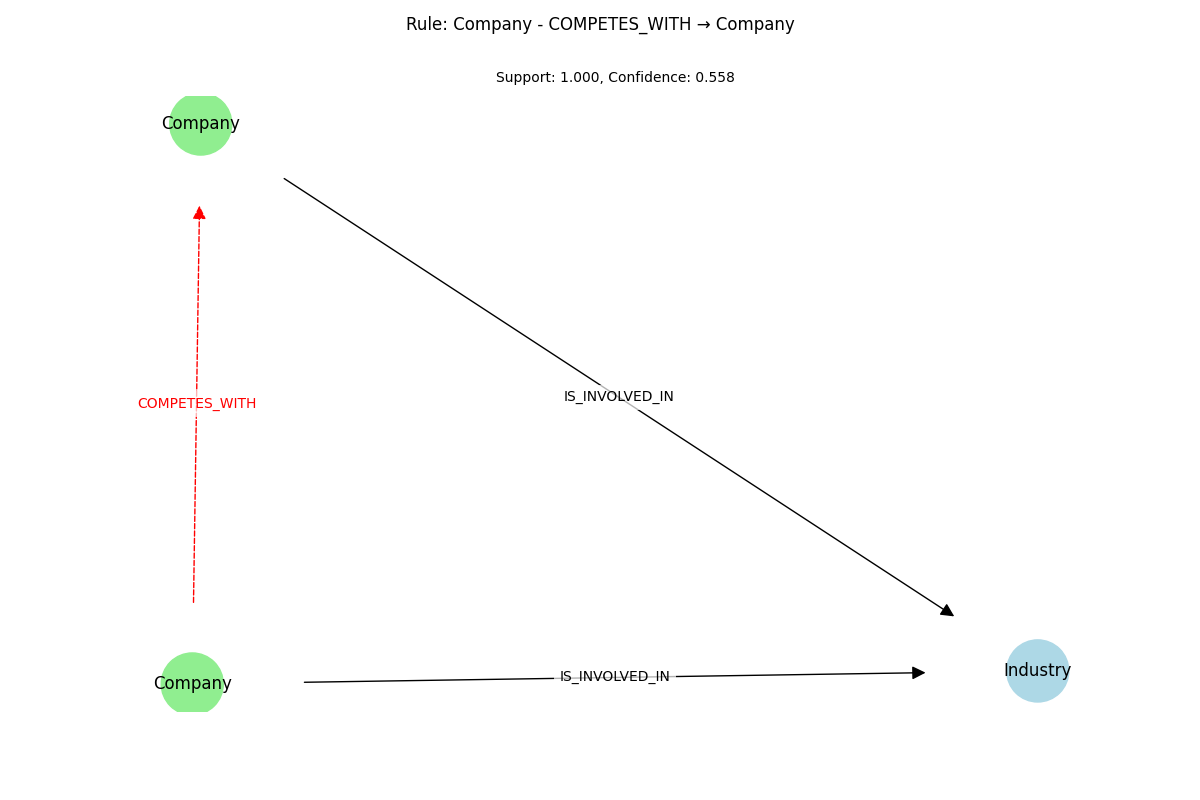

In [2]:
Image(r"../output/rules/Company_COMPETES_WITH_Company_0.png")

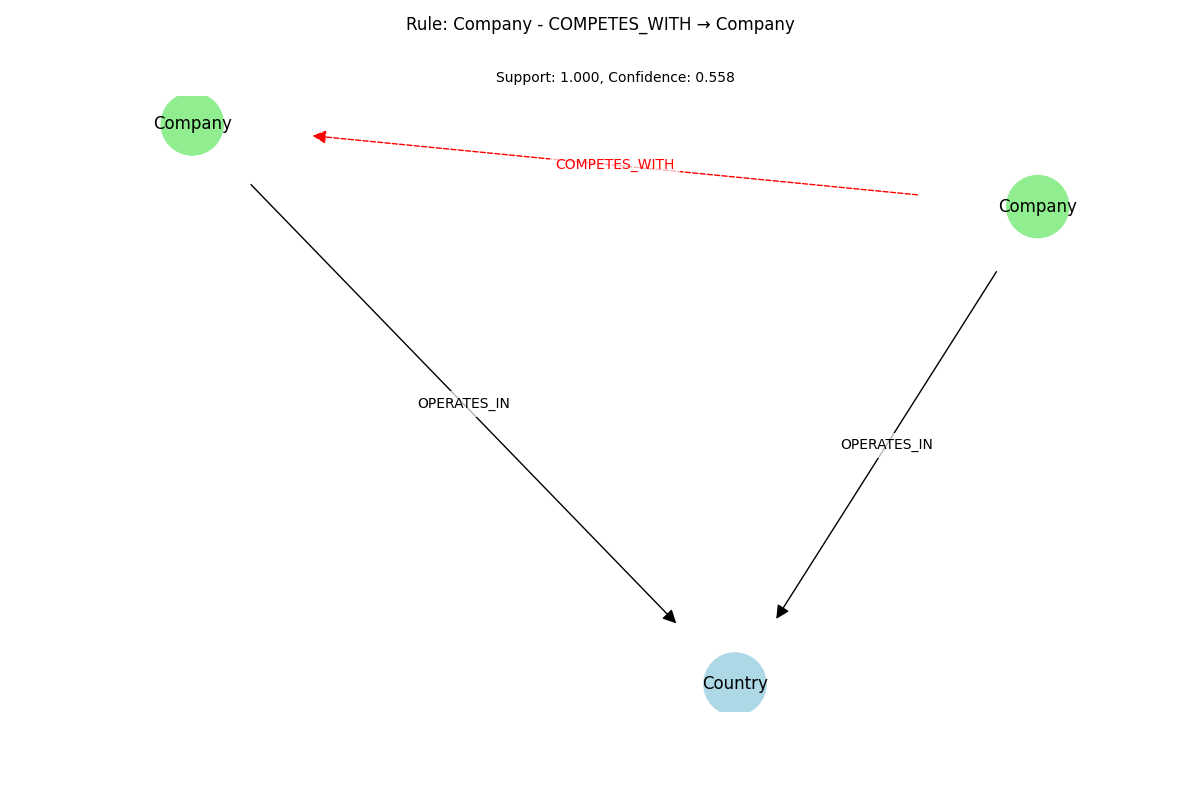

In [3]:
Image(r"../output/rules/Company_COMPETES_WITH_Company_1.png")

Likewise for the SUBSIDIARY_OF relationship, the same patterns were extracted by the algorithm.
1. They operate in the same country.
2. They are involved in the same industry.

In [6]:
patterns['SUBSIDIARY_OF']

{Pattern((Company0)-[:IS_INVOLVED_IN]->(Industry2),
 (Company1)-[:IS_INVOLVED_IN]->(Industry2),
 supp=1, conf=0.5),
 Pattern((Company0)-[:OPERATES_IN]->(Country2),
 (Company1)-[:OPERATES_IN]->(Country2),
 supp=1, conf=0.5)}